# Normalizing flows in Pyro

We want to approximate some target density $p(\mathbf{x},\mathbf{z})$ with an approximate distribution $q$. To do so,
let $\varepsilon\sim q(\varepsilon)$, and let $\{f_i\}_{i=1}^N$ be a set of $N$ invertible functions (*normalizing flows*). We repeatedly apply function composition such as 
$$
\varepsilon \mapsto f_1 \circ \varepsilon \mapsto ... \mapsto f_N \circ ... \circ f_1 \circ \varepsilon,
$$
which defines a variational distribution $q(\mathbf{z}\lvert\mathbf{x})$.

The optimization problem consists in finding the optimal $f_1,..,f_N$ such as to maximize the ELBO:
$$
\mathcal{L}=\mathbb{E}_{\varepsilon}[p(\mathbf{x},\mathbf{z})-q(\mathbf{z}|\mathbf{x})]
$$

Here, we assume that $p(\mathbf{x},\mathbf{z})$ is exactly known as `p_z`, which gets passed as an argument to both the model and the guide. It is used to score samples from $q(\mathbf{z}\lvert\mathbf{x})$.

**Model**: $p(\mathbf{x},\mathbf{z})$, has to be from `torch.distributions` or extended by Pyro transforms.

**Guide**: $q(\mathbf{z}\lvert \mathbf{x})$, the variational approximation to the true posterior. This is the NF.

In [1]:
from pyro.nn import AutoRegressiveNN
from pyro import distributions
import pyro, torch
import numpy as np
import matplotlib.pyplot as plt
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
%matplotlib inline

from torch.distributions.multivariate_normal import MultivariateNormal as mvn
import seaborn as sns

import torch.nn as nn

torch.manual_seed(0)
np.random.seed(0)

class NormalizingFlow(nn.Module):
    def __init__(self,dim,
                      n_flows,
                     base_dist=lambda dim:distributions.Normal(torch.zeros(dim), torch.ones(dim)),
                     flow_type=lambda kwargs:distributions.transforms.RadialFlow(**kwargs),
                     args={'flow_args':{'dim':2}}):
        super(NormalizingFlow, self).__init__()
        self.dim = dim
        self.n_flows = n_flows
        self.base_dist = base_dist(dim)
        self.uuid = np.random.randint(low=0,high=10000,size=1)[0]
        
        
        """
        If the flow needs an autoregressive net, build it for every flow
        """
        if 'arn_hidden' in args:
            self.arns = nn.ModuleList([AutoRegressiveNN(dim,
                                                        args['arn_hidden'],
                                                        param_dims=[self.dim]*args['n_params']) for _ in range(n_flows)])
    
        """
        Initialize all flows
        """
        self.nfs = []
        for f in range(n_flows):
            if 'autoregressive_nn' in args['flow_args']:
                args['flow_args']['autoregressive_nn'] = self.arns[f]
            nf = flow_type(args['flow_args'])
            self.nfs.append(nf)

        """
        This step assumes that nfs={f_i}_{i=1}^N and that base_dist=N(0,I)
        Then, register the (biejctive) transformation Z=nfs(eps), eps~base_dist
        """
        self.nf_dist = distributions.TransformedDistribution(self.base_dist, self.nfs)
        
        self._register()
        
    def _register(self):
        """
        Register all N flows with Pyro
        """
        for f in range(self.n_flows):
            nf_module = pyro.module("%d_nf_%d" %(self.uuid,f), self.nfs[f])

    def target(self,x,p_z):
        """
        p(x,z), but x is not required if there is a true density function (p_z in this case)
        
        1. Sample Z ~ p_z
        2. Score it's likelihood against p_z
        """
        with pyro.plate("data", x.shape[0]):
            p = p_z()
            z = pyro.sample("latent",p)
            pyro.sample("obs", p, obs=x.reshape(-1, self.dim))
        
    def model(self,x,p_z):
        """
        q(z|x), once again x is not required
        
        1. Sample Z ~ nfs(eps), eps ~ N(0,I)
        
        This is the NN being trained
        """
        self._register()
        with pyro.plate("data", x.shape[0]):
            pyro.sample("latent", self.nf_dist)

    def sample(self,n):
        """
        Sample a batch of (n,dim)
        
        Bug: in IAF and IAFStable, the dimensions throw an error (todo)
        """
        return self.nf_dist.sample(torch.Size([n]))
    
    def log_prob(self,z):
        """
        Returns log q(z|x) for z (assuming no x is required)
        """
        return self.nf_dist.log_prob(z)

The above class simply allows to combine multiple NF layers (of the same kind/hyperparameters). However, it would be possible to mix, say, affine layers with radial and followed by IAF.

We define the default parameters for the most commonly used flows:
- NAF
- Planar
- Radial
- Householder
- Sylvester

Note that IAF and Polynomial flows don't work out of the box as of now (dimension mismatch issues).

In [2]:
flow = distributions.transforms.SylvesterFlow
base_dist = lambda dim:distributions.Normal(torch.zeros(dim), torch.ones(dim))
dim = 2
n_flows = 3

if 'InverseAutoregressiveFlow' in flow.__name__:
    args = {'arn_hidden':[64],
            'n_params': 2,
            'flow_args':{'autoregressive_nn':None}
            }
elif flow.__name__ == 'NeuralAutoregressive':
    args = {'arn_hidden':[64],
                 'n_params': 3,
                 'flow_args':{'hidden_units':64,'autoregressive_nn':None}
           }
elif flow.__name__ == 'PolynomialFlow':
    args = {'arn_hidden':[64],
                 'n_params': 2,
                 'flow_args':{'input_dim':dim,'autoregressive_nn':None,'count_sum':3,'count_degree':1}
           }
elif flow.__name__ == 'PlanarFlow':
    args = {'flow_args':{'input_dim':dim}}
elif flow.__name__ == 'RadialFlow':
    args = {'flow_args':{'input_dim':dim}}
elif flow.__name__ in ['HouseholderFlow']:
    args = {'flow_args':{'input_dim':dim,
                         'count_transforms':2}}
elif flow.__name__ in ['SylvesterFlow']:
    args = {'flow_args':{'input_dim':dim,
                         'count_transforms':2}}
else:
    raise('Flow not found')
    
nf_obj = NormalizingFlow(dim=dim,
                      n_flows=n_flows,
                     base_dist=base_dist,
                     flow_type=lambda kwargs:flow(**kwargs),
                     args=args)

The normalizing flow model is initialized randomly (probably Kaimin). 

We can sample $\varepsilon \sim \mathcal{N}(0,I)$ and then pass it through an untrained NF to visualize the output.

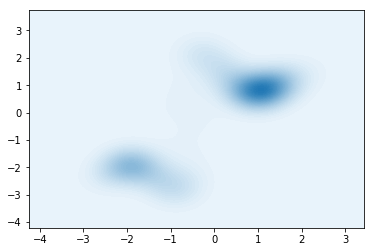

In [23]:
samples = nf_obj.sample(1000).numpy()

sns.kdeplot(data=samples[:,0],data2=samples[:,1],n_levels=60, shade=True)
plt.show()

Now that the model is built, we can define a target density to fit. For example, a mixture of Gaussians defined by:

$$
\begin{cases}
j \sim \text{Cat}([0.5,0.5])\\
Z \sim \mathcal{N}(\mu_j,\Sigma_j)
\end{cases},
$$
where
$$
\mu_1 = (1,1), \Sigma_1 = (1,1),\\
\mu_2 = (-2,-2), \Sigma_2 = (1,1)
$$

The method `p_z` returns the `torch.distributions` object instead of samples, since this allows to compute the log-likelihood of parameters as well as entropy, etc. 

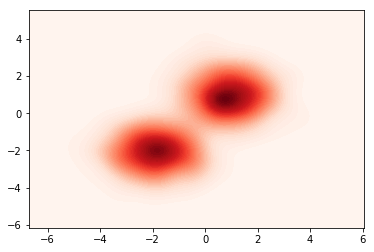

In [4]:
def p_z(mu1=torch.FloatTensor([1,1]),
        mu2=torch.FloatTensor([-2,-2]),
        Sigma1 = torch.FloatTensor([1,1]),
        Sigma2 = torch.FloatTensor([1,1]),
        component_logits = torch.FloatTensor([0.5,0.5]) # mixture weights
       ):

    
    
    
    dist = distributions.MixtureOfDiagNormals(locs=torch.stack([mu1,mu2],axis=0),
                                       coord_scale=torch.stack([Sigma1,Sigma2],axis=0),
                                       component_logits=component_logits)
    return dist

samples = p_z().sample(torch.Size([1000])).numpy()

sns.kdeplot(data=samples[:,0],data2=samples[:,1],n_levels=60, shade=True,cmap="Reds")
plt.show()

Now that both $q(\mathbf{z}\lvert\mathbf{x})$ and $p(\mathbf{x},\mathbf{z})$ are defined, we can start training the guide wrt to it's NF parameters.

In [5]:
adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(nf_obj.target, nf_obj.model, optimizer, loss=Trace_ELBO())
n_steps = 2000 # number of batches
dist = p_z() # true distribution
# do gradient steps
losses = []
for step in range(n_steps):
    data = dist.rsample(torch.Size([128])) # using a batch of 128 new data points every step
    loss = svi.step(data,p_z) # analogous to opt.step() in PyTorch
    losses.append(loss)
    if step % 100 == 0:
        print(loss)

606.4810180664062
442.5220947265625
350.348876953125
292.1370544433594
272.21307373046875
259.8561096191406
190.2799072265625
198.51370239257812
237.82369995117188
199.65435791015625
187.28436279296875
189.45309448242188
187.41226196289062
170.92938232421875
169.35205078125
156.18997192382812
163.49246215820312
152.12704467773438
135.185302734375
167.228271484375


After training, we can once again visualize the samples from the (now trained) guide $q(\mathbf{z}\lvert\mathbf{x})$

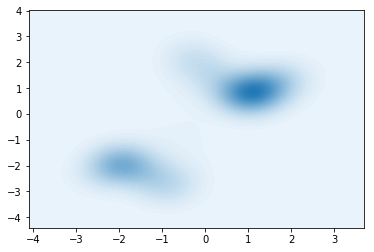

In [6]:
samples = nf_obj.sample(500).numpy()

sns.kdeplot(data=samples[:,0],data2=samples[:,1],n_levels=60, shade=True)
plt.show()

We can also visualize the outputs of intermediate flows $f_1,...,f_{N-1}$

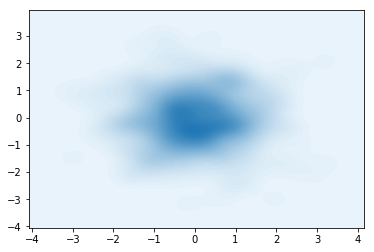

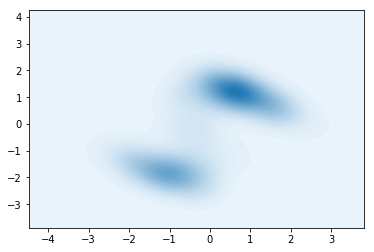

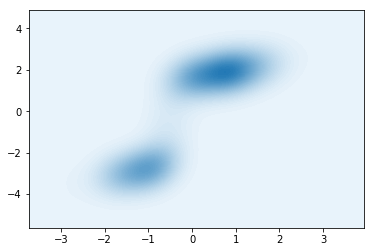

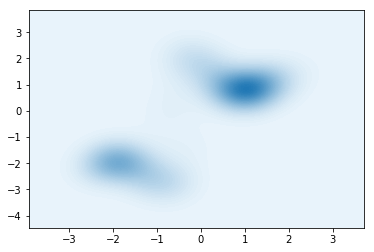

In [7]:
for f in range(n_flows+1):
    intermediate_nf = distributions.TransformedDistribution(nf_obj.base_dist, nf_obj.nfs[:f])

    samples = intermediate_nf.sample(torch.Size([500])).numpy()

    sns.kdeplot(data=samples[:,0],data2=samples[:,1],n_levels=60, shade=True)
    plt.show()

# Applications

NFs (or more generally, invertible neural networks) have been used in:
- Generative models with $1\times1$ invertible convolutions [Link to paper](https://arxiv.org/abs/1807.03039)
- Reinforcement learning, to improve upon the (not always optimal) Gaussian policy [Link to paper](https://arxiv.org/abs/1905.06893)
- Simulating attraction-repulsion forces in actor-critic [Link to paper](https://arxiv.org/abs/1909.07543)

## SAC-NF (Soft Actor-Critic with Normalizing Flows)

In [22]:
from pyro.nn import DenseNN

flow = distributions.transforms.SylvesterFlow
base_dist = lambda dim:distributions.Normal(torch.zeros(dim), torch.ones(dim))
dim = 2
n_flows = 1

class SAC_NF(NormalizingFlow):
    def __init__(self,dim,
                      n_flows,
                     base_dist=lambda dim:distributions.Normal(torch.zeros(dim), torch.ones(dim)),
                     flow_type=lambda kwargs:distributions.transforms.RadialFlow(**kwargs),
                     args={'flow_args':{'dim':2}}):
        super(NormalizingFlow,self).__init__()
        self.dim = dim
        self.n_flows = n_flows
        self.base_dist = base_dist(dim)
        self.uuid = np.random.randint(low=0,high=10000,size=1)[0]
        
        self.split_dim = 1
        
        
        """
        If the flow needs an autoregressive net, build it for every flow
        """
        if 'arn_hidden' in args:
            self.arns = nn.ModuleList([AutoRegressiveNN(dim,
                                                        args['arn_hidden'],
                                                        param_dims=[self.dim]*args['n_params']) for _ in range(n_flows)])
    
        self.hypernet = DenseNN(self.split_dim, [10*dim], [dim-self.split_dim, dim-self.split_dim])
        self.affine = distributions.transforms.AffineCoupling(self.split_dim,self.hypernet)
        
        self.nfs = [self.affine]
        for f in range(n_flows):
            if 'autoregressive_nn' in args['flow_args']:
                args['flow_args']['autoregressive_nn'] = self.arns[f]
            nf = flow_type(args['flow_args'])
            self.nfs.append(nf)
#         self.nfs.append(distributions.transforms.TanhTransform())
        self.nf_dist = distributions.TransformedDistribution(self.base_dist, self.nfs)
        self.nfs_module = nn.ModuleList(self.nfs)
        
        self._register()
        
        
    def _register(self):
        """
        Register all N flows with Pyro
        """
        for f in range(self.n_flows):
            nf_module = pyro.module("%d_nf_%d" %(self.uuid,f), self.nfs[f])

sac_nf_obj = SAC_NF(dim=dim,
                     n_flows=n_flows,
                     base_dist=base_dist,
                     flow_type=lambda kwargs:flow(**kwargs),
                     args=args)

The SAC-NF transform relies on the SAC architecture and applies the following transformations:
    
$$
\begin{align}
\begin{split}
\varepsilon\sim\mathcal{N}(0,I)\\
z_0 = \varepsilon \odot \sigma(\mathbf{s}) + \mu(\mathbf{s})\\
z_N = f_N \circ ... f_1 (z_0)
\end{split}
\end{align}
$$

Now, using the code for the mixture of Gaussians, we sample a single spherical Gaussian centered at $(5,5)$. The `AffineTransform` should (in theory), be enough to fit this perfectly.

Due to some bug (?) in the Affine layer, only the $y$ coordinate can be fitted, since $d>0$, meaning that only dimensions starting from 1 can be affected by the scaling.

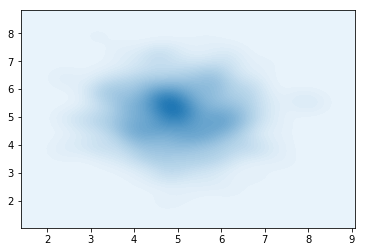

In [24]:
def dist():
    return p_z(mu1=torch.FloatTensor([5,5]),mu2=torch.FloatTensor([5,5]),component_logits = torch.FloatTensor([1.,0.]))

samples = dist().sample(torch.Size([500])).numpy()

sns.kdeplot(data=samples[:,0],data2=samples[:,1],n_levels=60, shade=True)
plt.show()

5002.748382568359
2411.296600341797
2097.863739013672
1921.4746398925781
2007.9555969238281
1932.3137512207031
2005.7548828125
1963.2335205078125
1977.4140319824219
1970.154541015625
1980.2752990722656
1896.7272644042969
2000.2195739746094
1994.8067321777344
1960.1996154785156
2030.6659545898438
1950.1164855957031
1935.8016662597656
1964.7090759277344
1897.6198425292969


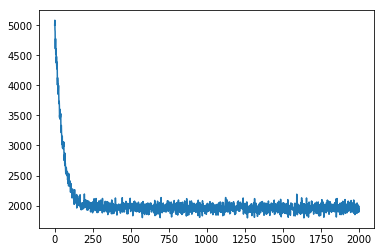

In [18]:
adam_params = {"lr": 0.005, "betas": (0.90, 0.999)}
optimizer_sac_nf = Adam(adam_params)

# setup the inference algorithm
svi = SVI(sac_nf_obj.target, sac_nf_obj.model, optimizer_sac_nf, loss=Trace_ELBO())
n_steps = 2000 # number of batches
# do gradient steps
losses = []

for step in range(n_steps):
    
    data = dist().rsample(torch.Size([128])) # using a batch of 128 new data points every step
    loss = svi.step(data,dist) # analogous to opt.step() in PyTorch
    losses.append(loss)
    if step % 100 == 0:
        print(loss)
plt.plot(losses)
plt.show()

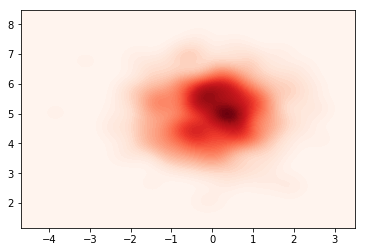

In [19]:
samples = sac_nf_obj.sample(500).numpy()

sns.kdeplot(data=samples[:,0],data2=samples[:,1],n_levels=60, shade=True,cmap="Reds")
plt.show()

## Custom losses for NF

In theory, built-in losses such as `Trace_ELBO` can be converted to PyTorch losses, on which any member of `torch.optim` can be used.

However, if one wants to use the log-probability method (e.g. to compute the entropy of the transform), then you must implement a custom SVI loss.

**guide_trace**: this uses poutine and samples along the path defined by the guide;
**model_trace**: same as above, but uses the model to sample. `poutine.replay` indicates that we score the samples from the guide against the model.

In [16]:
from pyro import poutine

opt = torch.optim.Adam(sac_nf_obj.parameters(),lr=1e-3)
x=dist().rsample(torch.Size([100]))
y=sac_nf_obj.sample(100)
print("Sylvester flow 1 norm before grad step: %f"%sac_nf_obj.nfs_module[1].R().norm().item())
def simple_elbo(model, guide, *args, **kwargs):
    extra_tensor = kwargs.pop('extra_tensor', None)
    print(extra_tensor)
    # run the guide and trace its execution
    guide_trace = poutine.trace(guide).get_trace(*args, **kwargs)
    # run the model and replay it against the samples from the guide
    model_trace = poutine.trace(
        poutine.replay(model, trace=guide_trace)).get_trace(*args, **kwargs)
    # construct the elbo loss function
    return -1*(model_trace.log_prob_sum() - guide_trace.log_prob_sum())

svi = SVI(sac_nf_obj.target, sac_nf_obj.model, optimizer_sac_nf, loss=simple_elbo)
svi.step(x,dist,extra_tensor=y)
print("Sylvester flow 1 norm after grad step: %f"%sac_nf_obj.nfs_module[1].R().norm().item())

Sylvester flow 1 norm before grad step: 0.010553
tensor([[-0.6532, -3.2266],
        [-1.4369, -2.2642],
        [ 1.7831,  1.8866],
        [ 1.2057, -3.3546],
        [ 0.8843, -1.9962],
        [-0.6511, -2.8947],
        [ 1.2770, -0.8812],
        [ 2.3425,  6.0786],
        [-0.3239, -2.1769],
        [-1.6838, -1.7401],
        [-1.0360, -1.6916],
        [-1.1975, -1.7610],
        [ 1.0814, -4.0814],
        [ 0.8691, -2.8339],
        [ 1.0740, -1.1211],
        [ 0.4533, -2.3326],
        [ 0.1536, -0.8533],
        [-0.4876, -2.1652],
        [-0.2706, -2.1278],
        [ 0.8022, -1.0923],
        [ 0.7711, -1.3674],
        [ 0.9884, -1.5060],
        [ 1.1776, -3.0835],
        [-0.0668, -1.9782],
        [ 0.2606, -1.9875],
        [ 1.0887, -1.5709],
        [ 0.1087, -2.3162],
        [ 1.3835,  0.9984],
        [ 0.9251, -2.8095],
        [-0.4262, -1.6906],
        [ 0.3341, -3.4285],
        [ 2.1652,  8.1632],
        [-0.0157, -0.8455],
        [-0.2593, -3.7607],